In [6]:
import fitsio
import os
import os.path
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import tensorflow as tf
from astropy.io import fits
import astropy
import json

Sloan data at NERSC is stored in this directory

In [7]:
sdss_dir = "/global/project/projectdirs/cosmo/data/sdss/dr16/sdss/spectro/redux/v5_13_0/"

Data is in subdirectories.

Spectra are organied by plate.

For the moment work with "combined" spectra.  A single object may be observed several times and the spectrograph has blue and red channels.  These data are available but the simple thing is to work where these data are combined to make one spectrum per object.

The combined spectra for the plate are in fits files with the name "spPlate*.fits

see https://data.sdss.org/datamodel/files/BOSS_SPECTRO_REDUX/RUN2D/PLATE4/spPlate.html

In [8]:
# save the names of the data and redshift files
datafiles_wz=[]
datafiles_nz=[]
z_files=[]
for dirpath, dirnames, filenames in os.walk(sdss_dir):
    for filename in [f for f in filenames if f.startswith("spPlate")]:
        data_file   = os.path.join(dirpath, filename)
        file_ending = filename[7::]
        z_file      = os.path.join(dirpath,'v5_13_0','spZbest'+file_ending)
        if os.path.exists(z_file):
            z_files.append(z_file)
            datafiles_wz.append(os.path.join(dirpath, data_file))
        else:
            datafiles_nz.append(os.path.join(dirpath, data_file))
            print(z_file)
        

In [9]:
len(datafiles_wz)*2/60/60
import os

In [10]:
local_path = '/global/cscratch1/sd/vboehm/Datasets/SDSS_BOSS_data/'
%
with open(os.path.join(local_path,'datafiles.txt'), 'w') as file:
    json.dump(datafiles_wz, file)

UsageError: Line magic function `%` not found.


In [ ]:
with open(os.path.join(local_path,'z_files.txt'), 'w') as file:
    json.dump(z_files, file)

In [ ]:
with open(os.path.join(local_path,'z_files.txt'), 'r') as infile:
    for line in infile:
        z_files = json.loads(line)


## Look at one file

In [ ]:
h    = fitsio.read_header(z_files[0])

In [ ]:
h    = fitsio.FITS(z_files[0])

In [ ]:
new_file_names = "/global/cscratch1/sd/vboehm/Datasets/SDSS_BOSS_data/"


for ii, (datafile, zfile) in enumerate(zip(datafiles_wz[0:8],z_files[0:8])):
    print(ii)
    hdulist = fits.open(datafile)

    c0   = hdulist[0].header['coeff0']
    c1   = hdulist[0].header['coeff1']
    npix = hdulist[0].header['naxis1']
    wave = 10.**(c0 + c1 * np.arange(npix))

    bunit = hdulist[0].header['bunit']
    print(bunit)
    flux  = hdulist[0].data
    ivar  = hdulist[1].data
    amask = np.asarray(hdulist[2].data==0,dtype=int)
    hdulist.close()
    hdulist = 0

    #hdulist = fits.open(z_file)
    zstruc  = hdulist[1].data
    print(z_struc['z'])
#     hdulist.close()
#     hdulist = 0

    hdu       = fits.PrimaryHDU(flux)
    hdu_amask = fits.ImageHDU(amask,name='amask')
    hdu_ivar  = fits.ImageHDU(amask,name='ivar')
    hdu_wave  = fits.ImageHDU(wave,name='wlen')

    
#     c1 = fits.Column(name='redshift', array=zstruc['z'], format='E')
#     c2 = fits.Column(name='class', array=zstruc['class'], format='6A')
#     c3 = fits.Column(name='subclass', array=zstruc['subclass'], format='6A')
#     c4 = fits.Column(name='index', array=ii*1000+np.arange(1000), format='K')

#    cdef = fits.ColDefs([c1,c2,c3,c4])

#    table_hdu = fits.BinTableHDU.from_columns(cdef)

    hdulist = fits.HDUList([hdu, hdu_amask, hdu_ivar, hdu_wave])
    hdulist.writeto(os.path.join(new_file_names,'spAll%d.fits'%ii))
#     hdulist.close()
#     hdulist = 0



In [40]:
hdulist = fits.open(os.path.join(new_file_names,'spAll%d.fits'%0))

In [58]:
name = os.path.join(new_file_names,'spAll%d.fits'%0)

In [18]:
# ff = fits.open(name)

# for ii in range(10):
#     data =1*fits.getdata(name, 0).astype('float32')
#     print(data.shape)
#     im = tf.expand_dims(data[ii],-1)
#     print(im)

In [34]:
pp=hdulist['PRIMARY'].data

In [35]:
pp.shape

(1000, 4647)

In [36]:
pp[0]

array([ 16.493845 ,   7.7203794,   7.1141124, ..., -18.153131 ,
       -18.152998 , -18.152863 ], dtype=float32)

In [105]:
h    = fitsio.read_header(datafiles[0])
fits = fitsio.FITS(datafiles[0])

In [50]:
# The wavelength solution is saved here
print(h["COEFF0"],h["COEFF1"])

3.5508 0.0001


In [42]:
wave = 10**(h["COEFF0"]+h["COEFF1"]*np.arange(4647))

In [20]:
img  = fits[0].read()
img.shape

(1000, 4647)

In [106]:
fits


  file: /global/project/projectdirs/cosmo/data/sdss/dr16/sdss/spectro/redux/v5_13_0/5290/spPlate-5290-55862.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      IMAGE_HDU       IVAR
  2      IMAGE_HDU       ANDMASK
  3      IMAGE_HDU       ORMASK
  4      IMAGE_HDU       WAVEDISP
  5      BINARY_TBL      PLUGMAP
  6      IMAGE_HDU       SKY

### Wavelengths
All spectra in a plate have the same wavelength solution.
All plates have very similar wavelength solutions.
Instead of being saved as an array, the wavelengths of the spectra are saved in the header.

3.5508 0.0001


### Flux, variance, and mask
The data include the flux (in physical units), inverse variance, masks that indicate a problem with a pixel

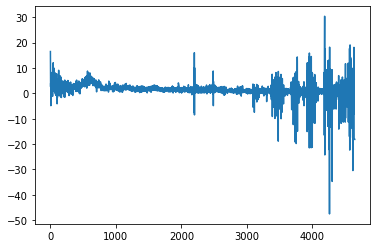

In [21]:
plt.plot(np.squeeze(fits[0][0,:]))

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
from sdss_pae.sdss_dataset import SDSS

In [3]:
ds, info =tfds.load('SDSS', data_dir='/global/cscratch1/sd/vboehm/Datasets/',with_info=True)

/global/project/projectdirs/cosmo/data/sdss/dr16/sdss/spectro/redux/v5_13_0/5290/spPlate-5290-55862.fits
/global/project/projectdirs/cosmo/data/sdss/dr16/sdss/spectro/redux/v5_13_0/10739/spPlate-10739-58255.fits
/global/project/projectdirs/cosmo/data/sdss/dr16/sdss/spectro/redux/v5_13_0/5802/spPlate-5802-56309.fits
/global/project/projectdirs/cosmo/data/sdss/dr16/sdss/spectro/redux/v5_13_0/4628/spPlate-4628-55646.fits
/global/project/projectdirs/cosmo/data/sdss/dr16/sdss/spectro/redux/v5_13_0/6512/spPlate-6512-56567.fits
/global/project/projectdirs/cosmo/data/sdss/dr16/sdss/spectro/redux/v5_13_0/5338/spPlate-5338-56002.fits
/global/project/projectdirs/cosmo/data/sdss/dr16/sdss/spectro/redux/v5_13_0/7635/spPlate-7635-56979.fits
/global/project/projectdirs/cosmo/data/sdss/dr16/sdss/spectro/redux/v5_13_0/5203/spPlate-5203-56034.fits
/global/project/projectdirs/cosmo/data/sdss/dr16/sdss/spectro/redux/v5_13_0/4029/spPlate-4029-55618.fits
/global/project/projectdirs/cosmo/data/sdss/dr16/sdss

Dataset sdss downloaded and prepared to /global/cscratch1/sd/vboehm/Datasets/sdss/1.0.0. Subsequent calls will reuse this data.


In [4]:
info

tfds.core.DatasetInfo(
    name='sdss',
    version=1.0.0,
    description='selected features from SDSS dataset in',
    homepage='https://dataset-homepage/',
    features=FeaturesDict({
        'and_mask': Tensor(shape=(None, 1), dtype=tf.int32),
        'coeffs': Tensor(shape=(3, 1), dtype=tf.float32),
        'flux': Tensor(shape=(None, 1), dtype=tf.float32),
        'inv_var': Tensor(shape=(None, 1), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
        'redshift': tf.float32,
    }),
    total_num_examples=10000,
    splits={
        'train': 10000,
    },
    supervised_keys=None,
    citation="""""",
    redistribution_info=,
)

In [5]:
ds['train'].take(1)

<TakeDataset shapes: {and_mask: (None, 1), coeffs: (3, 1), flux: (None, 1), inv_var: (None, 1), label: (), redshift: ()}, types: {and_mask: tf.int32, coeffs: tf.float32, flux: tf.float32, inv_var: tf.float32, label: tf.int64, redshift: tf.float32}>

In [6]:
ii = 0
for image in tfds.as_numpy(ds['train']):
    if ii<3:
        print(image['redshift'], image['label'])
        ii+=1


1.514166 1
0.56254554 1
0.8726299 2
